In [1]:
import simulate

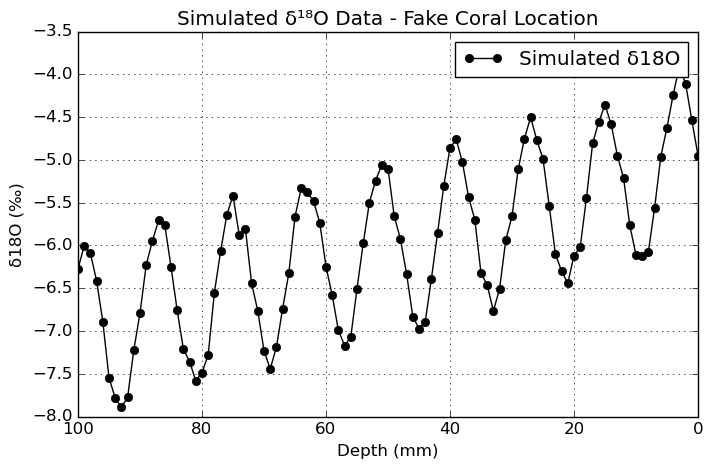

Coral δ¹⁸O Data:
     Depth (mm)  d18o (per mil)
0             0       -4.950329
1             1       -4.533826
2             2       -4.109206
3             3       -3.907697
4             4       -4.237390
..          ...             ...
96           96       -6.890388
97           97       -6.413894
98           98       -6.093463
99           99       -6.003459
100         100       -6.275512

[101 rows x 2 columns]


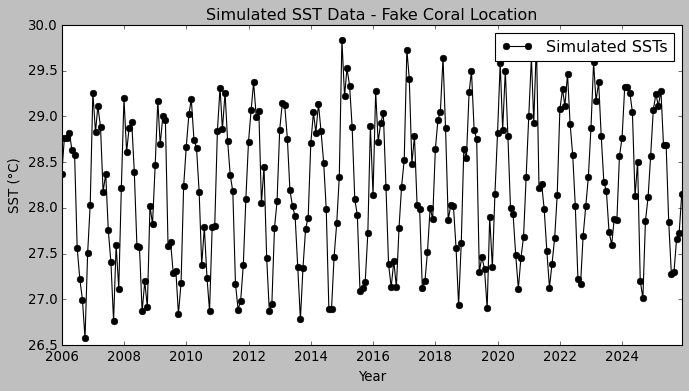

SST Data:
     Years Ago   SST (°C)
0     0.000000  28.373806
1     0.083682  28.764885
2     0.167364  28.762664
3     0.251046  28.822661
4     0.334728  28.627910
..         ...        ...
235  19.665272  27.279631
236  19.748954  27.298563
237  19.832636  27.654507
238  19.916318  27.729209
239  20.000000  28.153334

[240 rows x 2 columns]


In [2]:
run simulate

In [3]:
import csv
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [6]:
df_d18o = pd.read_csv("simulated_d18o_dataset.csv")  # columns: depth_mm, delta18O

In [7]:
df_sst = pd.read_csv("simulated_sst_dataset.csv")    # columns: years_ago, sst (deg C)

In [8]:
# Detrend both series and add columns to the datasets
df_d18o["detrended"] = detrend(df_d18o["d18o (per mil)"])
df_sst["detrended"] = detrend(df_sst["SST (°C)"])

In [76]:
# z-score normalization so that signals can be easily compared; mean = 0, std = 1
df_sst["normalized"] = (df_sst["SST (°C)"] - df_sst["SST (°C)"].mean()) / df_sst["SST (°C)"].std()
df_d18o["normalized"] = (df_d18o["d18o (per mil)"] - df_d18o["d18o (per mil)"].mean()) / df_d18o["d18o (per mil)"].std()

# finding sst peaks 
sst_peaks, _ = find_peaks(df_sst["norm"], distance=6)  # corals grow roughly 6 mm per season, so wait at least 6 peaks before picking the highest one
# Find δ18O troughs (we negate the normalized δ18O to find troughs instead of peaks)
d18o_troughs, _ = find_peaks(-df_d18o["normalized"], distance=6)

In [77]:
# extract peaks from datasets
sst_summers = df_sst.iloc[sst_peaks] # .iloc returns only the rows at the trough locations
d18o_summers = df_d18o.iloc[d18o_troughs] # .iloc returns only the rows at the trough locations

In [79]:
# creating new dataset with the age points
num_tiepoints = min(len(sst_summers), len(d18o_summers)) # limit the matching to the shorter list to avoid index errors (if there are more sst peaks than d18o troughs, for example)
anchor_depths = d18o_summers["Depth (mm)"].values[:num_tiepoints] # new array of depths with only the numebr of tiepoints
anchor_ages = sst_summers["Years Ago"].values[:num_tiepoints] # new array of ages with only the number of tiepoints

In [81]:
# interpolate the full age model
interp_func = interp1d(anchor_depths, anchor_ages, kind='linear', fill_value="extrapolate") # fill_value = extrapolate: points outside the data range will be extrapolated
df_d18o["age_model"] = interp_func(df_d18o["Depth (mm)"]) # create a new column with the age model

In [ ]:
df_d18o.columns # see columns?

In [83]:
# Interpolate δ¹⁸O over Even Time Steps
even_time = np.arange(df_d18o["age_model"].min(), df_d18o["age_model"].max(), 0.1)
even_d18o = np.interp(even_time, df_d18o["age_model"], df_d18o["d18o (per mil)"])